In [7]:
from survival_analysis import prepare_df, obtain_survival_fractions, obtain_total_alive_count
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.optimize import minimize
from scipy.integrate import quad

In [8]:
df = prepare_df()

In [9]:
df_analysis = df.copy()

# Add age column
df_analysis['age'] = ((pd.to_datetime("2023-01-01")) - df_analysis['Entry Date']).dt.days / 365.25

# Add dead column
df_analysis['Dead'] = 1 - df_analysis['status']

# Drop ages > 30
df_analysis = df_analysis[df_analysis['age'] <= 30]

df_analysis.head()

,uen,Sector,status,Exit Date,Entry Date,Region,age,Dead
0,53376145W,N,0,2020-04-30 09:36:00,2018-01-13 10:32:56,NR,4.963723,1
1,53290857X,S,1,NaT,2015-02-26 12:02:44,CR,7.843943,0
3,200412424K,G,1,NaT,2004-09-28 17:56:29,WR,18.255989,0
4,53396472E,H,0,2020-10-10 09:36:00,2019-04-11 21:20:43,CR,3.723477,1
5,48376900B,S,0,1999-12-24 04:48:00,1993-04-12 00:00:00,NER,29.722108,1


[0.12218057 0.05819898 8.97407875 9.99474502]


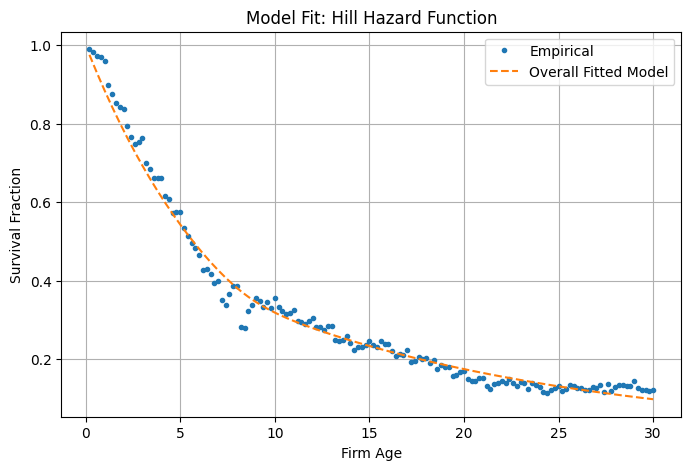

In [10]:
# ---- Step 1: Define the Hill-type hazard function ----

def hill_hazard(a, mu_ub, mu_lb, K, m):
    return mu_ub - (mu_ub - mu_lb) * (a**m) / (a**m + K**m + 1e-10)  # Add epsilon to avoid div by 0

# ---- Step 2: Define survival function S(a) using quad integration ----

def hill_survival_function(a, mu_ub, mu_lb, K, m):
    result, _ = quad(lambda s: hill_hazard(s, mu_ub, mu_lb, K, m), 0, a)
    return np.exp(-result)

# ---- Step 3: Vectorized function to compute model survival over array of ages ----

def model_survival_curve_hill(ages, mu_ub, mu_lb, K, m):
    return np.array([hill_survival_function(a, mu_ub, mu_lb, K, m) for a in ages])

# ---- Step 4: Objective function to minimize squared error between model and empirical ----

def objective_hill(params, ages, observed_survival):
    mu_ub, mu_lb, K, m = params
    if mu_ub < mu_lb or mu_ub < 0 or mu_lb < 0:
        return np.inf
    predicted = model_survival_curve_hill(ages, mu_ub, mu_lb, K, m)
    return np.sum((predicted - observed_survival)**2)

# ---- Step 5: Fit parameters ----

def fit_survival_model(ages, survival_fractions, initial_guess=[0.1, 0.05, 5, 10]):
    '''
    Returns the params of the Hill function model giving the least squares error

    Inputs:
    ages = firm age bins
    survival_fractions = survival fraction of firms in each age bin
    initial_guess = initial guess for params [mu_ub, mu_lb, K, m]

    ''' 
    bounds = [(0.01, 0.3), (1e-10, 0.3), (0.1, 30), (0.5, 100)]
    result = minimize(objective_hill, initial_guess, args=(ages, survival_fractions), bounds=bounds)
    return result

# Example usage

# Create age bins (e.g., every 2 years)
bins = np.arange(0, df_analysis['age'].max() + 1, 0.2)
df_analysis['age_bin'] = pd.cut(df_analysis['age'], bins)


# Compute survival fraction per bin
surv_frac = df_analysis.groupby('age_bin', observed=True)['status'].mean().reset_index()
surv_frac = surv_frac.loc[~(surv_frac == 0).any(axis=1)]
survival_fractions = np.array(surv_frac['status'])
ages = surv_frac['age_bin'].apply(lambda x: x.right)

result = fit_survival_model(ages, survival_fractions, [0.2, 0.05, 5, 10])
best_params = result.x
overall_predicted_curve = model_survival_curve_hill(ages, *best_params)
print(best_params)

# ---- Plot ----
plt.figure(figsize=(8, 5))
plt.plot(ages, survival_fractions, 'o', markersize = 3, label="Empirical")
plt.plot(ages, overall_predicted_curve, '--', label="Overall Fitted Model")
plt.xlabel("Firm Age")
plt.ylabel("Survival Fraction")
plt.title("Model Fit: Hill Hazard Function")
plt.grid(True)
plt.legend()
plt.show()

In [11]:
region_list = ['NR','WR','CR','ER','NER']

for region in region_list:
    survival_frac, ages = obtain_survival_fractions(df_analysis, 'Region', region)
    result = fit_survival_model(ages, survival_frac, [0.2, 0.05, 8, 7])
    best_params = result.x
    predicted_curve = model_survival_curve_hill(ages, *best_params)
    print(f'{region}: {best_params}')

    # # Plot model against empirical
    # plt.figure(figsize=(8, 5))
    # plt.plot(ages, survival_frac, 'o', markersize = 3, label="Empirical")
    # plt.plot(ages, predicted_curve, '--', label="Fitted Model")
    # plt.plot(ages, overall_predicted_curve, '--', label="Overall Fitted Model")
    # plt.xlabel("Firm Age")
    # plt.ylabel("Survival Fraction")
    # plt.title(f"Model Fit: {region}")
    # plt.grid(True)
    # plt.legend()
    # plt.show()

NR: [0.13574074 0.01468059 8.98681513 6.98910326]
WR: [1.38430190e-01 2.40740341e-02 8.60832150e+00 1.00000000e+02]
CR: [ 0.10726301  0.07506882 10.92019458  7.17313311]
ER: [0.14417409 0.02666826 9.64267205 7.01975396]
NER: [1.49820212e-01 3.71745012e-02 8.25942813e+00 1.00000000e+02]


F: [7.95451385e-02 1.00000000e-10 2.86208538e+01 1.20016355e+01]


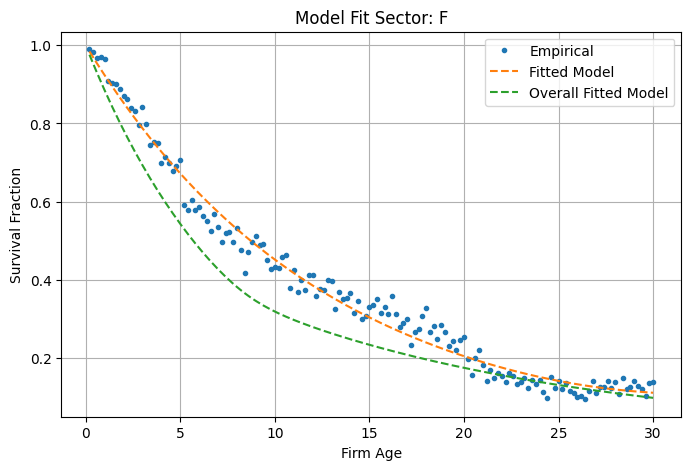

L: [7.57562545e-02 5.85672639e-03 2.61705419e+01 1.00001744e+01]


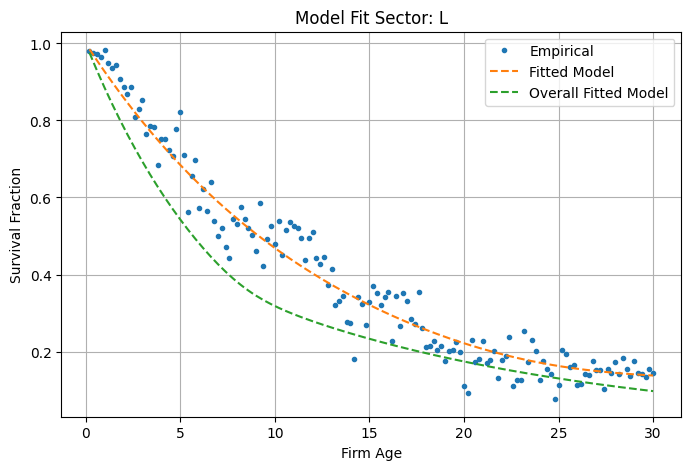

In [12]:
sector_list = ['F', 'L']

for sector in sector_list:
    survival_frac, ages = obtain_survival_fractions(df_analysis, 'Sector', sector)
    result = fit_survival_model(ages, survival_frac, [0.07998763144579782, 0.01, 26.17074846209418, 10.0])
    best_params = result.x
    predicted_curve = model_survival_curve_hill(ages, *best_params)
    print(f'{sector}: {best_params}')

    # Plot model against empirical
    plt.figure(figsize=(8, 5))
    plt.plot(ages, survival_frac, 'o', markersize = 3, label="Empirical")
    plt.plot(ages, predicted_curve, '--', label="Fitted Model")
    plt.plot(ages, overall_predicted_curve, '--', label="Overall Fitted Model")
    plt.xlabel("Firm Age")
    plt.ylabel("Survival Fraction")
    plt.title(f"Model Fit Sector: {sector}")
    plt.grid(True)
    plt.legend()
    plt.show()

In [13]:
sector_list = ['G', 'M', 'F', 'J', 'K', 'C', 'H', 'S', 'N', 'I', 'P', 'L', 'Q', 'R']

for sector in sector_list:
    survival_frac, ages = obtain_survival_fractions(df_analysis, 'Sector', sector)
    result = fit_survival_model(ages, survival_frac, [0.2, 0.03, 9, 5])
    best_params = result.x
    predicted_curve = model_survival_curve_hill(ages, *best_params)
    print(f'{sector}: {best_params}')

    # # Plot model against empirical
    # plt.figure(figsize=(8, 5))
    # plt.plot(ages, survival_frac, 'o', markersize = 3, label="Empirical")
    # plt.plot(ages, predicted_curve, '--', label="Fitted Model")
    # plt.plot(ages, overall_predicted_curve, '--', label="Overall Fitted Model")
    # plt.xlabel("Firm Age")
    # plt.ylabel("Survival Fraction")
    # plt.title(f"Model Fit Sector: {sector}")
    # plt.grid(True)
    # plt.legend()
    # plt.show()

G: [ 0.13557519  0.06119442  9.91855101 28.37901804]
M: [ 0.1097038   0.04915758 11.80623607  5.40536658]


c:\Users\chong\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


F: [0.1427709  0.02096383 8.82787014 4.98418077]
J: [ 0.13237394  0.05570531  9.59637699 10.65350551]
K: [7.23783498e-02 6.42624125e-03 1.74452097e+01 7.90755902e+00]
C: [1.01329542e-01 4.86099066e-02 8.52078240e+00 1.00000000e+02]
H: [1.56593834e-01 4.61012037e-02 6.90836250e+00 1.00000000e+02]
S: [1.40395122e-01 1.00000000e-10 1.29034246e+01 5.10492401e+00]
N: [1.23256986e-01 1.00000000e-10 1.62314002e+01 3.93349967e+00]
I: [1.27228077e-01 1.00000000e-10 2.07384939e+01 3.73566674e+00]
P: [1.21430444e-01 6.70227955e-02 9.47949818e+00 1.00000000e+02]
L: [0.14010446 0.02054281 8.80146452 4.98057058]


c:\Users\chong\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


Q: [7.87172720e-02 4.78399527e-02 7.56229192e+00 1.00000000e+02]
R: [1.33210761e-01 8.40125453e-02 8.82538519e+00 1.00000000e+02]


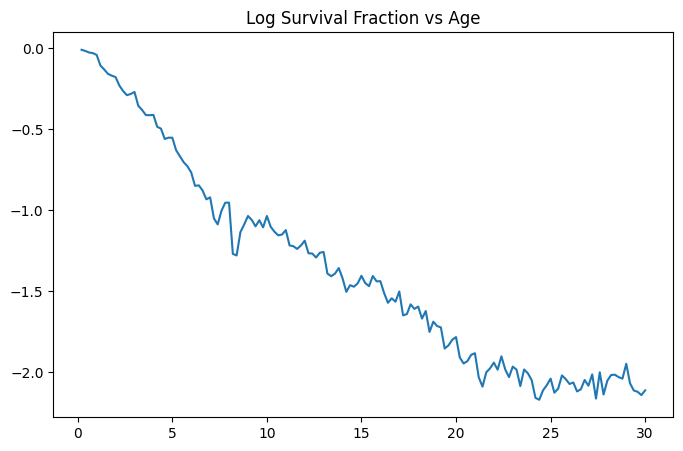

In [14]:
# Plotting log-survival fractions against age overall
survival_fractions, ages = obtain_survival_fractions(df_analysis)
plt.figure(figsize=(8, 5))
plt.plot(ages, np.log(survival_fractions))
plt.title("Log Survival Fraction vs Age")
plt.show()

In [76]:
# Negative log-likelihood for binomial MLE
def neg_log_likelihood_hill(params, ages, survivors, totals):
    mu_ub, mu_lb, K, m = params
    if mu_lb < 0 or mu_ub < mu_lb or K <= 0 or m <= 0:
        return np.inf

    S_vals = model_survival_curve_hill(ages, mu_ub, mu_lb, K, m)
    S_vals = np.clip(S_vals, 1e-12, 1 - 1e-12)  # avoid log(0)

    deaths = totals - survivors
    logL = np.sum(survivors * np.log(S_vals) + deaths * np.log(1 - S_vals))
    return -logL  # minimize negative log-likelihood

# Fit function
def fit_hill_model_mle(ages, survivors, totals, initial_guess=[0.12, 0.04, 10.0, 5.0]):
    '''
    ages = vector of ages
    survivors = number of survivors in age bin
    totals = total number of firms in age bin
    initial_guess = [mu_ub, mu_lb, K, m]

    returns best params according to MLE
    
    '''
    bounds = [(0.01, 0.3), (1e-10, 0.15), (0.01, 30), (0.5, 100)]
    constraints = {'type': 'ineq', 'fun': lambda x: x[0] - x[1]}  # mu_ub >= mu_lb
    result = minimize(neg_log_likelihood_hill, initial_guess,
                      args=(ages, survivors, totals),
                      bounds=bounds, constraints=constraints)
    return result


100.0
-732034.6894601445


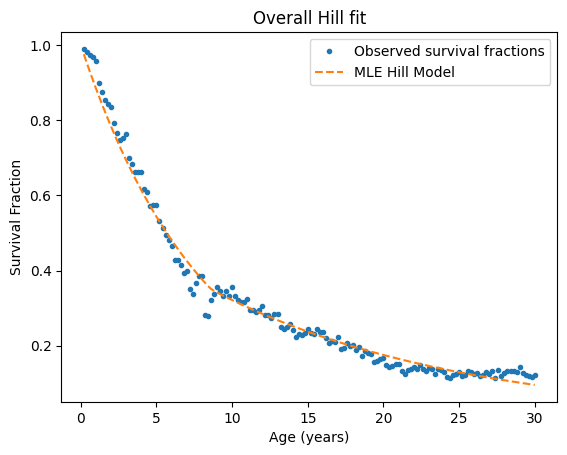

In [78]:
sf, ages = obtain_survival_fractions(df_analysis)

totals, survivors = obtain_total_alive_count(df_analysis)

mu_ub, mu_lb, K, m = fit_hill_model_mle(ages, survivors, totals, [0.13, 0.00001, 10.0, 3.0]).x

print(m)
print(-neg_log_likelihood_hill([mu_ub, mu_lb, K, m], ages, survivors, totals))

# Plot fit
fitted_S = model_survival_curve_hill(ages, mu_ub, mu_lb, K, m)

plt.plot(ages, sf, 'o', markersize = 3, label='Observed survival fractions')
plt.plot(ages, fitted_S, label='MLE Hill Model', linestyle='--')
plt.title(f'Overall Hill fit')
plt.xlabel('Age (years)')
plt.ylabel('Survival Fraction')
plt.legend()
plt.show()
#-736724.9764147416

NR [0.13699737059400022, 0.023557815372955357, 8.31380437771796, 100.0]


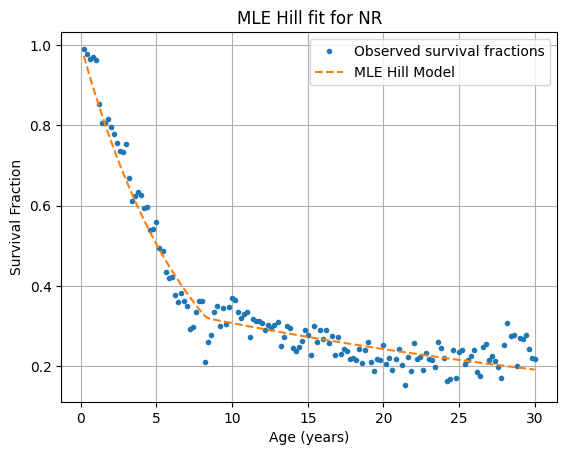

WR [0.139078810331312, 0.02564057762124559, 8.486254711280843, 100.0]


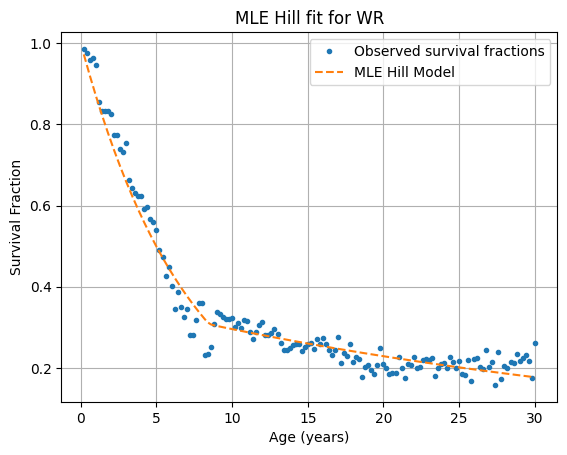

CR [0.10414114285388636, 1.0000002600891254e-10, 24.472059126233113, 3.717554873029177]


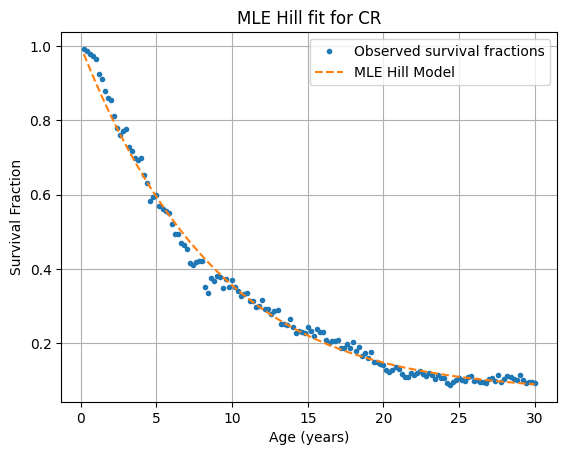

ER [0.14743279585190008, 0.03815368490403282, 8.499639794541732, 100.0]


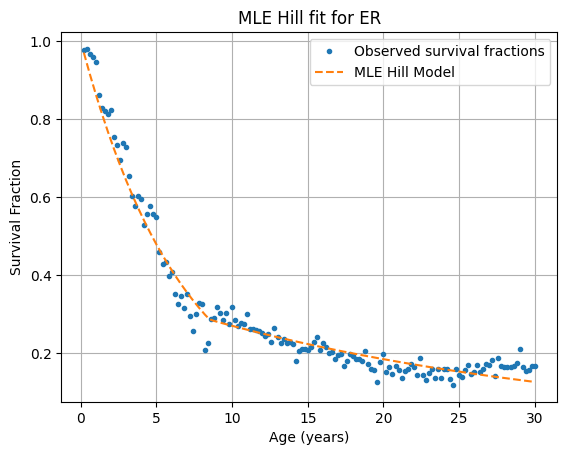

NER [0.15153779041951448, 0.03569549946261082, 8.27565878754413, 100.0]


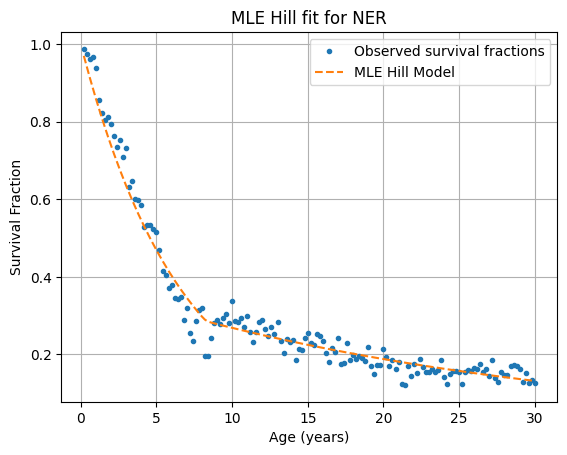

In [16]:
region_ll_hill = []
for fil in region_list:

    sf, ages = obtain_survival_fractions(df_analysis, 'Region', fil)

    totals, survivors = obtain_total_alive_count(df_analysis, 'Region', fil)

    mu_ub, mu_lb, K, m = fit_hill_model_mle(ages, survivors, totals).x
    
    print(f'{fil} {[float(x) for x in [mu_ub, mu_lb, K, m]]}')    

    # Plot fit
    fitted_S = model_survival_curve_hill(ages, mu_ub, mu_lb, K, m)

    # print(f'll for {fil}: {-neg_log_likelihood_hill([mu_ub, mu_lb, K, m], ages, survivors, totals)}')
    region_ll_hill.append(neg_log_likelihood_hill([mu_ub, mu_lb, K, m], ages, survivors, totals))

    plt.plot(ages, sf, 'o', markersize = 3, label='Observed survival fractions')
    plt.plot(ages, fitted_S, label='MLE Hill Model', linestyle='--')
    plt.title(f'MLE Hill fit for {fil}')
    plt.xlabel('Age (years)')
    plt.ylabel('Survival Fraction')
    plt.legend()
    plt.grid(True)
    plt.show()


In [17]:
sector_ll_hill = []
sector_list = ['G', 'M', 'F', 'J', 'K', 'C', 'H', 'S', 'N', 'I', 'P', 'L', 'Q', 'R']
parameters = []
for fil in sector_list:

    sf, ages = obtain_survival_fractions(df_analysis, 'Sector', fil)

    totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', fil)

    result1 = fit_hill_model_mle(ages, survivors, totals, [0.1, 0.04, 10, 5])
    result2 = fit_hill_model_mle(ages, survivors, totals, [0.2, 0.03, 7, 50])

    result = result1 if result1.fun < result2.fun else result2
    mu_ub, mu_lb, K, m = result.x
    print(f'{fil}: {[float(x) for x in result.x]}')

    # Plot fit
    fitted_S = model_survival_curve_hill(ages, mu_ub, mu_lb, K, m)

    print(f'll for {fil}: {-neg_log_likelihood_hill([mu_ub, mu_lb, K, m], ages, survivors, totals)}')
    sector_ll_hill.append(neg_log_likelihood_hill([mu_ub, mu_lb, K, m], ages, survivors, totals))
    parameters.append([float(x) for x in result.x])

    # plt.plot(ages, sf, 'o', markersize = 3, label='Observed survival fractions')
    # plt.plot(ages, fitted_S, label='MLE Hill Model', linestyle='--')
    # plt.title(f'MLE Hill fit for {fil}')
    # plt.xlabel('Age (years)')
    # plt.ylabel('Survival Fraction')
    # plt.legend()
    # plt.grid(True)
    # plt.show()
print(parameters)

G: [0.13771959172635478, 0.06036883390826407, 9.683527817633134, 37.16554776246212]
ll for G: -198294.65200673894
M: [0.10853423852842373, 0.06040203094166163, 10.324655252053779, 20.2431022135619]
ll for M: -106892.48710456165
F: [0.08284949629045338, 0.07532170024242305, 7.246072550255881, 99.9995683704219]
ll for F: -47781.66372947694
J: [0.13138419047680286, 0.06388417019228498, 9.027011437441391, 63.20559648903392]
ll for J: -56976.63236381628
K: [0.07012004488933721, 0.011080713775644365, 17.599335895302804, 11.726782536983189]
ll for K: -56212.87737674815
C: [0.09997597066599069, 0.049270691945483475, 8.699132957275232, 100.0]
ll for C: -39535.537979993445
H: [0.19014425302275023, 0.02801565370451772, 6.937673733970917, 100.0]
ll for H: -42974.850496180836
S: [0.14057209547880267, 1.0000000076278874e-10, 12.954253262292541, 5.19908018295204]
ll for S: -35752.28673670857
N: [0.12396232834152839, 1e-10, 16.432702180468965, 3.6763918799521744]
ll for N: -37012.32213217122
I: [0.126

$f(a) = (1+\alpha t) ^{-\lambda / \alpha}$  
$\mu(s) = \frac{\lambda}{1+\alpha s}$

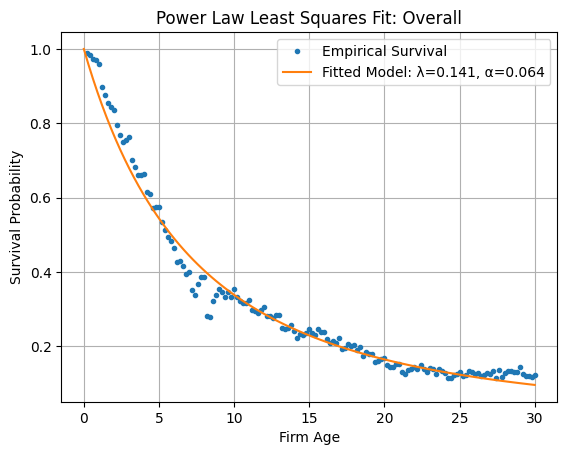

In [18]:
# ---- Closed-form survival function ----
def power_survival_function(t, lam, alpha):
    return (1 + alpha * t) ** (-lam / alpha)

# ---- Predict survival over a list of ages ----
def model_survival_curve_power(ages, lam, alpha):
    return np.array([power_survival_function(t, lam, alpha) for t in ages])

# ---- Least squares objective function ----
def objective_power(params, ages, observed_survival):
    lam, alpha = params
    if lam <= 0 or alpha < 0:
        return np.inf  # invalid parameters
    predicted = model_survival_curve_power(ages, lam, alpha)
    return np.sum((predicted - observed_survival) ** 2)

# ---- Fit the model using least squares ----
def fit_power_model(ages, survival_fractions):
    initial_guess = [0.2, 0.1]  # lambda, alpha
    bounds = [(1e-5, None), (0, None)]
    result = minimize(objective_power, initial_guess, args=(ages, survival_fractions), bounds=bounds)
    return result

# - ages: list or array of firm ages
# - survival_fractions: corresponding empirical survival fractions

# Create age bins (e.g., every 2 years)
bins = np.arange(0, df_analysis['age'].max() + 1, 0.2)
df_analysis['age_bin'] = pd.cut(df_analysis['age'], bins)
# Compute survival fraction per bin
survival_fractions, ages = obtain_survival_fractions(df_analysis)

result = fit_power_model(ages, survival_fractions)
lam_fit, alpha_fit = result.x

# Plot result
ages_sorted = np.linspace(0, max(ages), 100)
fitted_survival = model_survival_curve_power(ages_sorted, lam_fit, alpha_fit)

plt.plot(ages, survival_fractions, 'o', markersize=3, label='Empirical Survival')
plt.plot(ages_sorted, fitted_survival, label='Fitted Model: λ=%.3f, α=%.3f' % (lam_fit, alpha_fit))
plt.xlabel("Firm Age")
plt.ylabel("Survival Probability")
plt.title("Power Law Least Squares Fit: Overall")
plt.grid(True)
plt.legend()
plt.show()


In [19]:
def neg_log_likelihood_power(params, ages, survivors, totals):
    lam, alpha = params
    if lam <= 0 or alpha <= 0:
        return np.inf

    S = power_survival_function(ages, lam, alpha)
    S = np.clip(S, 1e-12, 1 - 1e-12)  # avoid log(0)
    deaths = totals - survivors

    logL = np.sum(survivors * np.log(S) + deaths * np.log(1 - S))
    return -logL

def fit_power_model_mle(ages, survivors, totals):
    initial_guess = [0.1, 0.1]  # lam, alpha
    bounds = [(1e-6, 1), (1e-6, 1)]
    result = minimize(neg_log_likelihood_power, initial_guess,
                      args=(ages, survivors, totals),
                      bounds=bounds)
    return result.x

-733837.9433015409


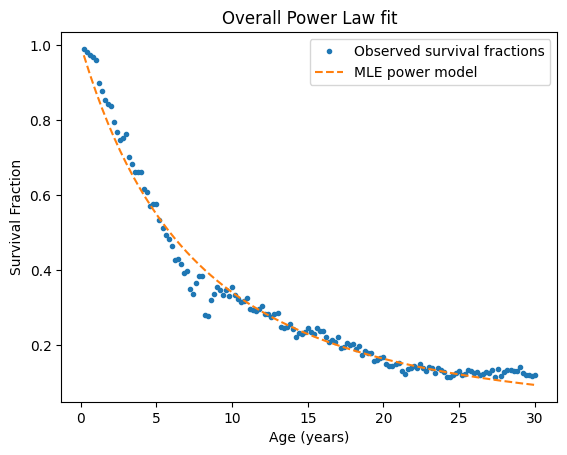

In [80]:
# Overall fit
sf, ages = obtain_survival_fractions(df_analysis)
totals, survivors = obtain_total_alive_count(df_analysis)
lam, alpha = fit_power_model_mle(ages, survivors, totals)

fitted_S = model_survival_curve_power(ages, lam, alpha)

print(-neg_log_likelihood_power([lam, alpha], ages, survivors, totals))

plt.plot(ages, sf, 'o', markersize = 3, label='Observed survival fractions')
plt.plot(ages, fitted_S, label='MLE power model', linestyle='--')
plt.title(f'Overall Power Law fit')
plt.xlabel('Age (years)')
plt.ylabel('Survival Fraction')
plt.legend()
plt.show()

ll for NR: -59567.6477521164
params lam, alpha are [0.1886195039277679, 0.18894739950045433]


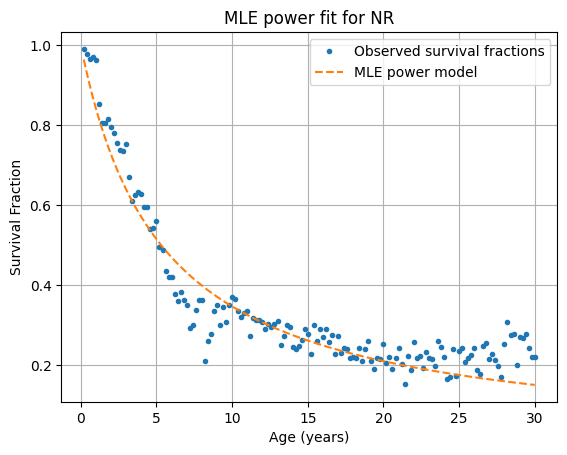

ll for WR: -96324.21879628443
params lam, alpha are [0.1889317727879867, 0.1784994064944407]


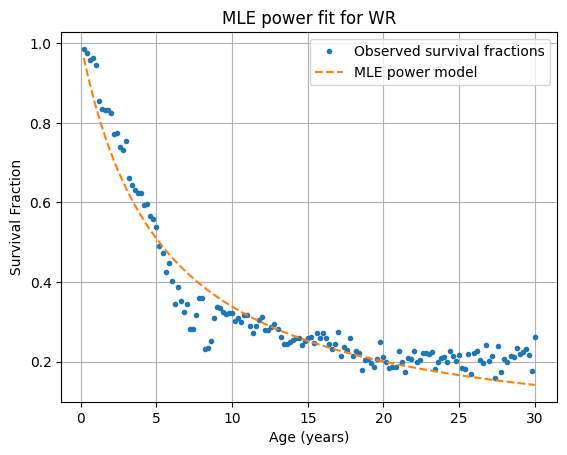

ll for CR: -420253.2008882553
params lam, alpha are [0.11069175500249837, 0.018335267155011367]


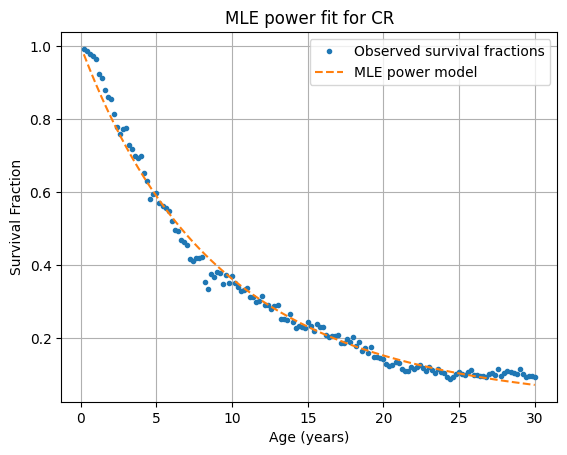

ll for ER: -71816.8062091888
params lam, alpha are [0.19149996695221363, 0.14322742737330993]


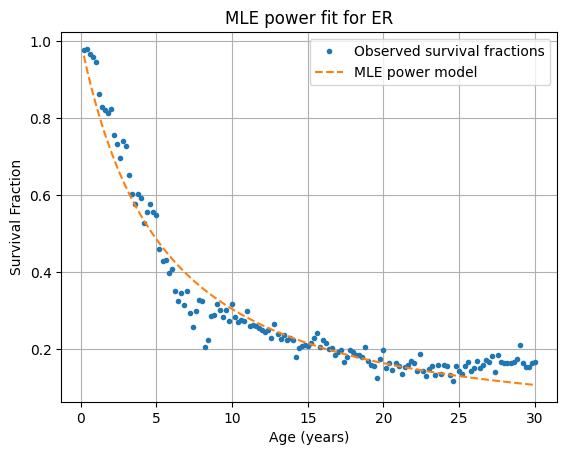

ll for NER: -82060.31237407553
params lam, alpha are [0.1989416274219653, 0.15602637405446237]


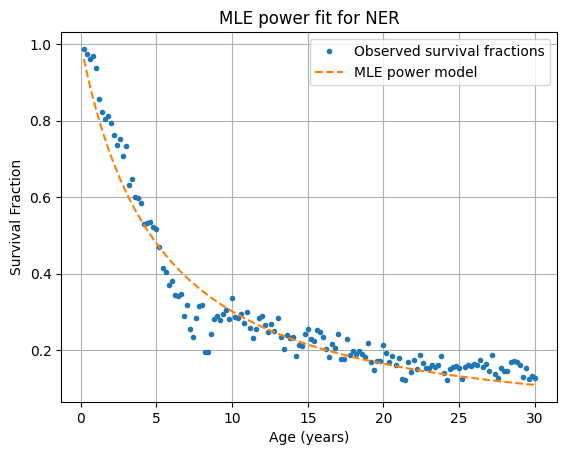

In [20]:
region_ll_power = []
for fil in region_list:

    sf, ages = obtain_survival_fractions(df_analysis, 'Region', fil)

    totals, survivors = obtain_total_alive_count(df_analysis, 'Region', fil)

    lam, alpha = fit_power_model_mle(ages, survivors, totals)

    # Plot fit
    fitted_S = model_survival_curve_power(ages, lam, alpha)

    print(f'll for {fil}: {-neg_log_likelihood_power([lam, alpha], ages, survivors, totals)}')
    region_ll_power.append(neg_log_likelihood_power([lam, alpha], ages, survivors, totals))

    print(f'params lam, alpha are {[float(x) for x in [lam, alpha]]}')

    plt.plot(ages, sf, 'o', markersize = 3, label='Observed survival fractions')
    plt.plot(ages, fitted_S, label='MLE power model', linestyle='--')
    plt.title(f'MLE power fit for {fil}')
    plt.xlabel('Age (years)')
    plt.ylabel('Survival Fraction')
    plt.legend()
    plt.grid(True)
    plt.show()

ll for G: -198944.67602002577
params lam, alpha are [0.15939620292528545, 0.06554740821430066]


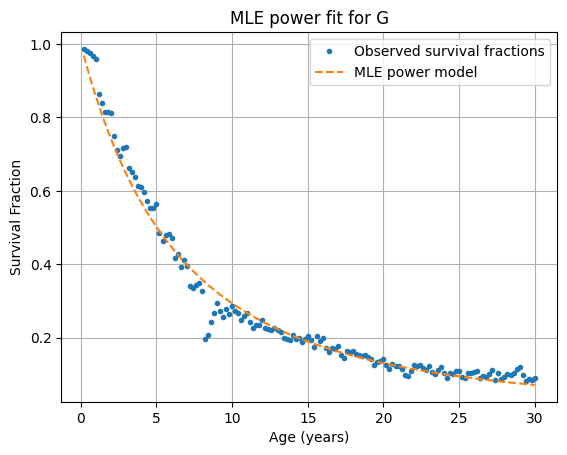

ll for M: -107109.28350819302
params lam, alpha are [0.11731541174879027, 0.034411617250405084]


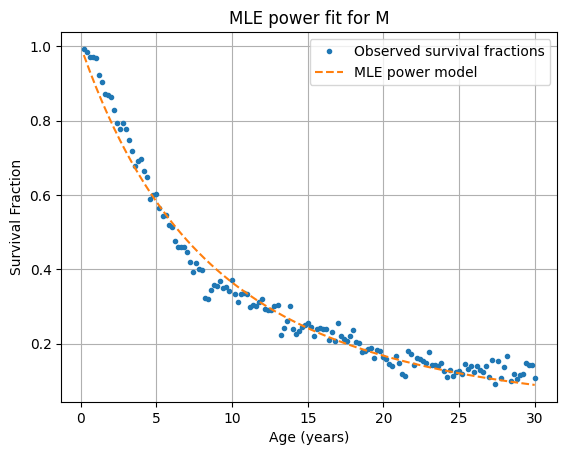

ll for F: -47789.79890249316
params lam, alpha are [0.08176472979107174, 0.003935373274942269]


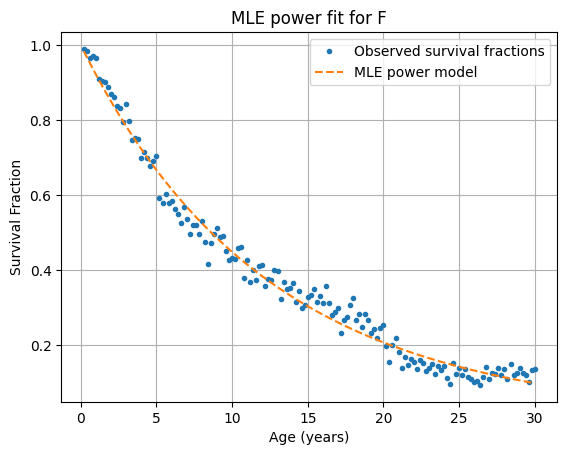

ll for J: -57151.028483457565
params lam, alpha are [0.14493123831512508, 0.05110384606085803]


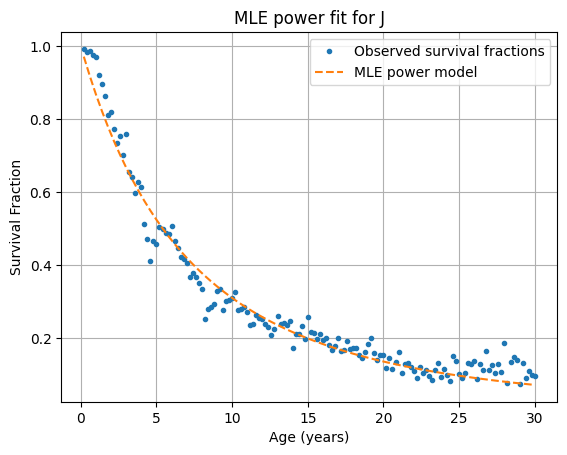

ll for K: -56413.996435860274
params lam, alpha are [0.07428516022902562, 0.0205752635062873]


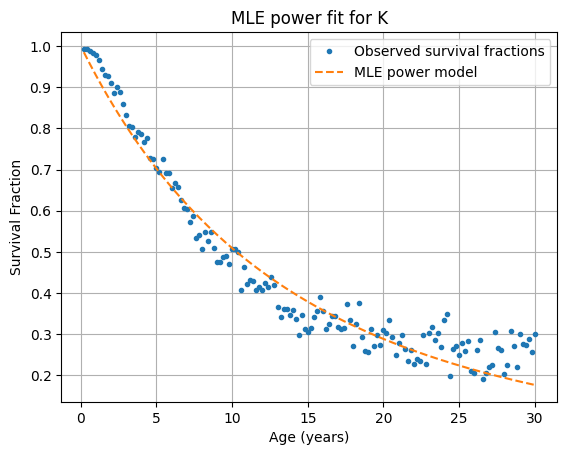

ll for C: -39594.27698304424
params lam, alpha are [0.11483004186551288, 0.06612012042977906]


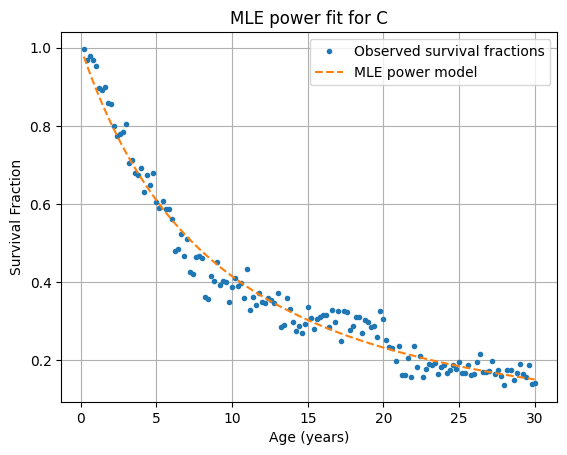

ll for H: -44001.194033551394
params lam, alpha are [0.28873886586023506, 0.2927118075549174]


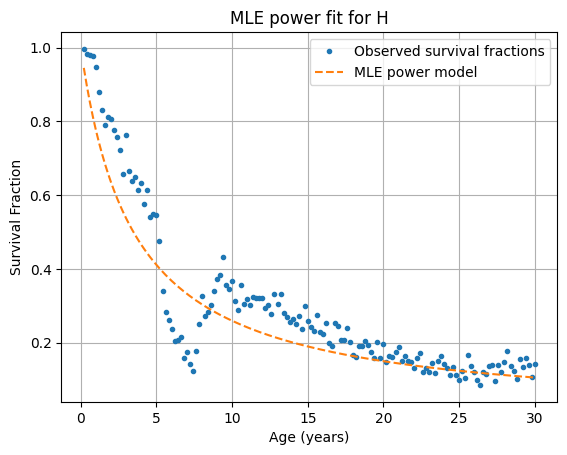

ll for S: -35960.844477007515
params lam, alpha are [0.18288352366120436, 0.11066508198985309]


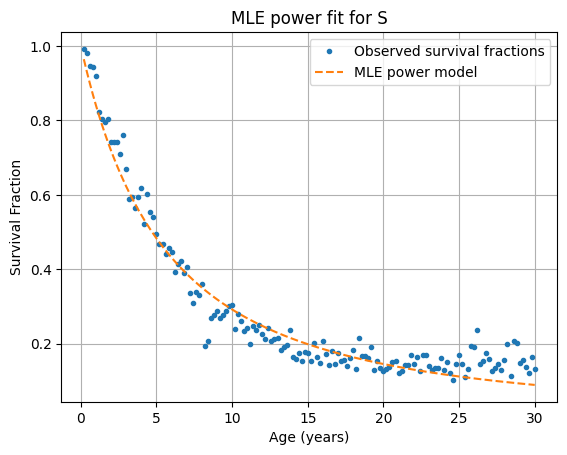

ll for N: -37101.62760374365
params lam, alpha are [0.14828698846245603, 0.06301547388836645]


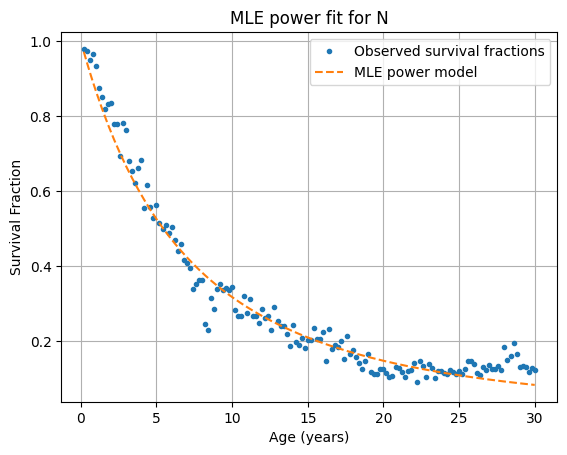

ll for I: -34289.22862246029
params lam, alpha are [0.13748459474217217, 0.026743625773472543]


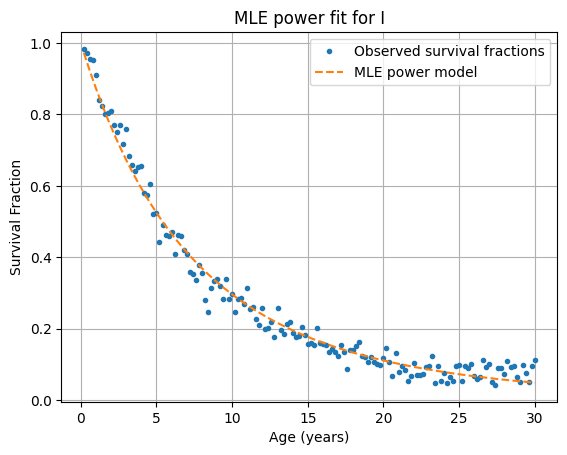

ll for P: -25212.251223789608
params lam, alpha are [0.13180537858715755, 0.03862507110559265]


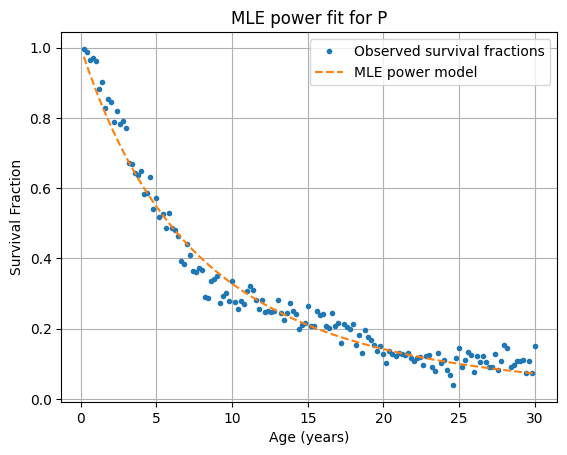

ll for L: -11928.88941323373
params lam, alpha are [0.07361777044103174, 0.0013500005115235382]


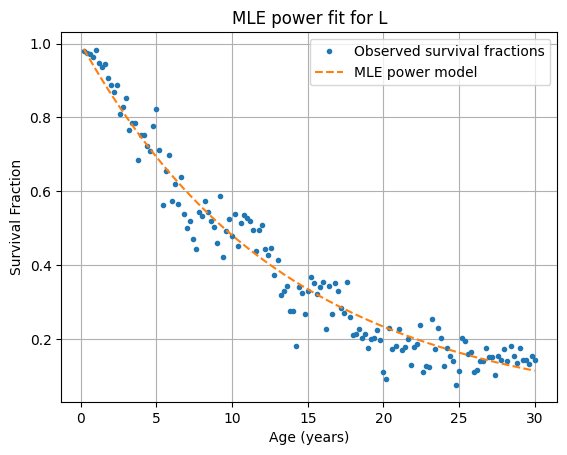

ll for Q: -12903.931859854327
params lam, alpha are [0.08504126422326021, 0.04439811725027947]


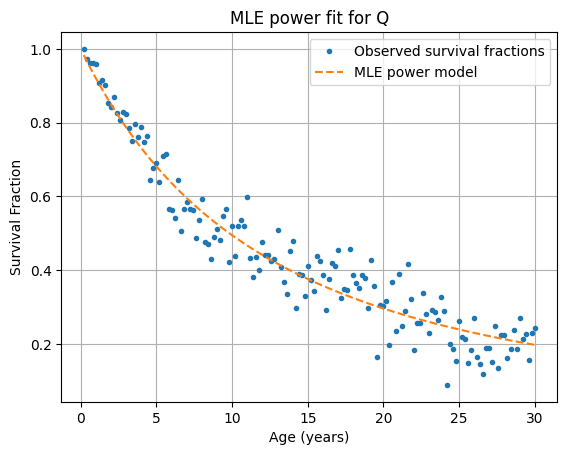

ll for R: -7533.920462008324
params lam, alpha are [0.13942475384045394, 0.02944071706324738]


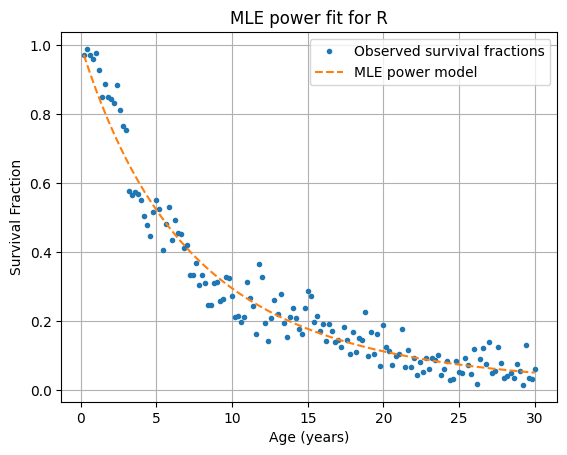

In [21]:
sector_ll_power = []

for fil in sector_list:

    sf, ages = obtain_survival_fractions(df_analysis, 'Sector', fil)

    totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', fil)

    lam, alpha = fit_power_model_mle(ages, survivors, totals)

    # Plot fit
    fitted_S = model_survival_curve_power(ages, lam, alpha)

    print(f'll for {fil}: {-neg_log_likelihood_power([lam, alpha], ages, survivors, totals)}')
    sector_ll_power.append(neg_log_likelihood_power([lam, alpha], ages, survivors, totals))

    print(f'params lam, alpha are {[float(x) for x in [lam, alpha]]}')

    plt.plot(ages, sf, 'o', markersize = 3, label='Observed survival fractions')
    plt.plot(ages, fitted_S, label='MLE power model', linestyle='--')
    plt.title(f'MLE power fit for {fil}')
    plt.xlabel('Age (years)')
    plt.ylabel('Survival Fraction')
    plt.legend()
    plt.grid(True)
    plt.show()

In [22]:
def compute_aic_bic(neg_logL, k, n):
    '''
    k = number of params
    n = number of observations
    '''

    aic = 2 * k + 2 * neg_logL
    bic = k * np.log(n) + 2 * neg_logL
    return aic, bic

In [23]:
# Hill function with number of params k=3, where hill coefficient is set constant at m=5

def hill3k_hazard(a, mu_ub, mu_lb, K):
    m = 10
    return mu_ub - (mu_ub - mu_lb) * (a**m) / (a**m + K**m + 1e-10)  # Add epsilon to avoid div by 0

# ---- Step 2: Define survival function S(a) using quad integration ----

def hill3k_survival_function(a, mu_ub, mu_lb, K):
    result, _ = quad(lambda s: hill3k_hazard(s, mu_ub, mu_lb, K), 0, a)
    return np.exp(-result)

# ---- Step 3: Vectorized function to compute model survival over array of ages ----

def model_survival_curve_hill3k(ages, mu_ub, mu_lb, K):
    return np.array([hill3k_survival_function(a, mu_ub, mu_lb, K) for a in ages])

# Negative log-likelihood for binomial MLE
def neg_log_likelihood_hill3k(params, ages, survivors, totals):
    mu_ub, mu_lb, K = params
    if mu_lb < 0 or mu_ub < mu_lb or K <= 0:
        return np.inf

    S_vals = model_survival_curve_hill3k(ages, mu_ub, mu_lb, K)
    S_vals = np.clip(S_vals, 1e-12, 1 - 1e-12)  # avoid log(0)

    deaths = totals - survivors
    logL = np.sum(survivors * np.log(S_vals) + deaths * np.log(1 - S_vals))
    return -logL  # minimize negative log-likelihood

# Fit function
def fit_hill3k_model_mle(ages, survivors, totals, initial_guess=[0.12, 0.04, 10.0]):
    '''
    ages = vector of ages
    survivors = number of survivors in age bin
    totals = total number of firms in age bin
    initial_guess = [mu_ub, mu_lb, K]

    returns best params according to MLE
    
    '''
    bounds = [(0.01, 0.3), (1e-10, 0.15), (0.01, 30)]
    constraints = {'type': 'ineq', 'fun': lambda x: x[0] - x[1]}  # mu_ub >= mu_lb
    result = minimize(neg_log_likelihood_hill3k, initial_guess,
                      args=(ages, survivors, totals),
                      bounds=bounds, constraints=constraints)
    return result

In [24]:
print("----Hill3k model fits (region)----")
region_list = ['NR','WR','CR','ER','NER']
region_ll_hill3k = []
for fil in region_list:
    sf, ages = obtain_survival_fractions(df_analysis, 'Region', fil)
    totals, survivors = obtain_total_alive_count(df_analysis, 'Region', fil)
    result = fit_hill3k_model_mle(ages, survivors, totals)
    print(f'{fil}: {[float(x) for x in result.x]}')
    # plt.plot(ages, sf, 'o', markersize = 3, label='Observed survival fractions')
    # plt.plot(ages, model_survival_curve_hill3k(ages, *result.x), label='MLE Hill3k Model', linestyle='--')
    # plt.title(f'MLE Hill3k fit for {fil}')
    # plt.xlabel('Age (years)')
    # plt.ylabel('Survival Fraction')
    # plt.legend()
    # plt.grid(True)
    # plt.show()
    region_ll_hill3k.append(result.fun)

print("----Hill3k model fits (sector)----")
sector_list = ['G', 'M', 'F', 'J', 'K', 'C', 'H', 'S', 'N', 'I', 'P', 'L', 'Q', 'R']
sector_ll_hill3k = []
parameters_3k = []
for fil in sector_list:
    sf, ages = obtain_survival_fractions(df_analysis, 'Sector', fil)
    totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', fil)
    # [7.23785797e-02, 6.43020350e-03, 1.74446268e+01]
    result1 = fit_hill3k_model_mle(ages, survivors, totals, [0.1, 0.05, 10])
    result2 = fit_hill3k_model_mle(ages, survivors, totals, [0.2, 0.03, 7])

    result = result1 if result1.fun < result2.fun else result2
    print(f'{fil}: {[float(x) for x in result.x]}')
    # plt.plot(ages, sf, 'o', markersize = 3, label='Observed survival fractions')
    # plt.plot(ages, model_survival_curve_hill3k(ages, *result.x), label='MLE Hill3k Model', linestyle='--')
    # plt.title(f'MLE Hill3k fit for {fil}')
    # plt.xlabel('Age (years)')
    # plt.ylabel('Survival Fraction')
    # plt.legend()
    # plt.grid(True)
    # plt.show()
    sector_ll_hill3k.append(result.fun)
    parameters_3k.append([float(x) for x in result.x])
print(parameters_3k)


region_aic_hill3k, region_bic_hill3k = compute_aic_bic(np.array(region_ll_hill3k), 3, len(ages))
sector_aic_hill3k, sector_bic_hill3k = compute_aic_bic(np.array(sector_ll_hill3k), 3, len(ages))

----Hill3k model fits (region)----
NR: [0.13708150243871836, 0.020317605511908796, 8.516817999633185]
WR: [0.13826864688980298, 0.02135469738796497, 8.855426945033392]
CR: [0.10174671369635926, 1e-10, 22.654387780812637]
ER: [0.14595189394128028, 0.03253917564615487, 9.0722950000213]
NER: [0.15208762609382429, 0.03355244203383181, 8.349430382152942]
----Hill3k model fits (sector)----
G: [0.13691607463783823, 0.05563612418162425, 10.321630605849528]
M: [0.10830975139189332, 0.057333515491559364, 10.862963835301928]
F: [0.08000219167272717, 1e-10, 29.021701723347906]
J: [0.1308321085184875, 0.05862651980538003, 9.740530923016202]
K: [0.07012394547111084, 0.007290222089530612, 18.089008251710723]
C: [0.09980383933102582, 0.04803355700085512, 8.909683510442468]
H: [0.1925942671045143, 0.027318610115234152, 6.8483329526083345]
S: [0.13854385394181648, 0.013432648249949575, 12.389938499574875]
N: [0.12254650424537371, 0.04203161810618856, 12.724065545012929]
I: [0.12498708212032622, 0.053391

In [25]:
def constant_survival_function(ages, mu):
    return np.exp(-mu * ages)

def model_survival_curve_constant(ages, mu):
    return np.array([constant_survival_function(_, mu) for _ in ages])

def neg_log_likelihood_constant(mu, ages, survivors, totals):
    if mu < 0:
        return np.inf
    S_vals = model_survival_curve_constant(ages, mu)
    S_vals = np.clip(S_vals, 1e-12, 1 - 1e-12) 
    deaths = totals - survivors
    logL = np.sum(survivors * np.log(S_vals) + deaths * np.log(1 - S_vals))
    return -logL

def fit_constant_model_mle(ages, survivors, totals, initial_guess=[0.01]):
    bounds = [(1e-6, None)]
    result = minimize(neg_log_likelihood_constant, initial_guess,
                      args=(ages, survivors, totals),
                      bounds=bounds)
    return result

0.06809608763032766


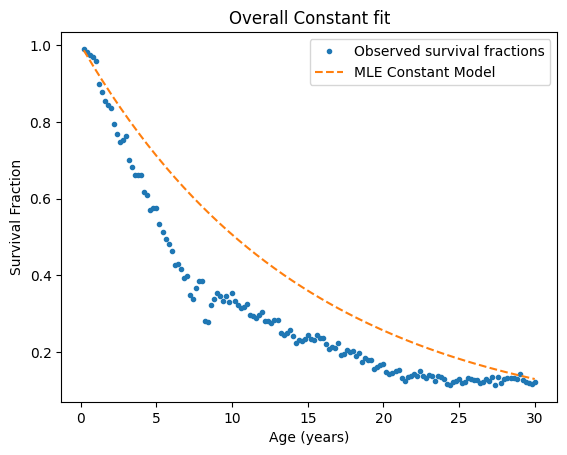

In [90]:
# Plot fit
sf, ages = obtain_survival_fractions(df_analysis)
totals, survivors = obtain_total_alive_count(df_analysis)
mu_const = fit_constant_model_mle(ages, survivors, totals, [10]).x[0]
fitted_S = model_survival_curve_constant(ages, mu_const)
print(mu_const)

plt.plot(ages, sf, 'o', markersize = 3, label='Observed survival fractions')
plt.plot(ages, model_survival_curve_constant(ages, mu_const), label='MLE Constant Model', linestyle='--')
plt.title(f'Overall Constant fit')
plt.xlabel('Age (years)')
plt.ylabel('Survival Fraction')
plt.legend()
plt.show()

In [87]:
region_ll_constant = []
for fil in region_list:
    sf, ages = obtain_survival_fractions(df_analysis, 'Region', fil)
    totals, survivors = obtain_total_alive_count(df_analysis, 'Region', fil)
    result = fit_constant_model_mle(ages, survivors, totals)
    # print(result.x[0])
    # plt.plot(ages, sf, 'o', markersize = 3, label='Observed survival fractions')
    # plt.plot(ages, model_survival_curve_constant(ages, result.x[0]), label='MLE Constant Model', linestyle='--')
    # plt.title(f'MLE Constant fit for {fil}')
    # plt.xlabel('Age (years)')
    # plt.ylabel('Survival Fraction')
    # plt.legend()
    # plt.grid(True)
    # plt.show()
    region_ll_constant.append(result.fun)

sector_ll_constant = []
for fil in sector_list:
    sf, ages = obtain_survival_fractions(df_analysis, 'Sector', fil)
    totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', fil)
    result = fit_constant_model_mle(ages, survivors, totals)
    sector_ll_constant.append(result.fun)

region_aic_constant, region_bic_constant = compute_aic_bic(np.array(region_ll_constant), 1, len(ages))
sector_aic_constant, sector_bic_constant = compute_aic_bic(np.array(sector_ll_constant), 1, len(ages))

In [27]:
region_aic_hill, region_bic_hill = compute_aic_bic(np.array(region_ll_hill), 4, len(ages))
region_aic_power, region_bic_power = compute_aic_bic(np.array(region_ll_power), 2, len(ages))
sector_aic_hill, sector_bic_hill = compute_aic_bic(np.array(sector_ll_hill), 4, len(ages))
sector_aic_power, sector_bic_power = compute_aic_bic(np.array(sector_ll_power), 2, len(ages))

In [28]:
region_df_aic = pd.DataFrame({
    'Region': region_list,
    'AIC_Hill': region_aic_hill,
    'AIC_Power': region_aic_power,
    'AIC_Hill3k': region_aic_hill3k,
    'AIC_Constant': region_aic_constant
})
region_df_aic.head()

,Region,AIC_Hill,AIC_Power,AIC_Hill3k,AIC_Constant
0,NR,118068.077116,119139.295504,118125.639916,2.582175e+07
1,WR,190914.527568,192652.437593,190985.435576,4.232045e+07
2,CR,839814.812453,840510.401777,839949.673056,2.080739e+08
3,ER,142705.091828,143637.612418,142726.437831,3.303534e+07
4,NER,162703.662049,164124.624748,162811.618992,3.751901e+07


In [29]:
region_df_bic = pd.DataFrame({
    'Region': region_list,
    'BIC_Hill': region_bic_hill,
    'BIC_Power': region_bic_power,
    'BIC_Hill3k': region_bic_hill3k,
    'BIC_Constant': region_bic_constant
})
region_df_bic.head()

,Region,BIC_Hill,BIC_Power,BIC_Hill3k,BIC_Constant
0,NR,118080.119657,119145.316775,118134.671822,2.582176e+07
1,WR,190926.570109,192658.458863,190994.467482,4.232046e+07
2,CR,839826.854994,840516.423047,839958.704962,2.080739e+08
3,ER,142717.134369,143643.633689,142735.469737,3.303534e+07
4,NER,162715.704590,164130.646019,162820.650898,3.751902e+07


In [30]:
sector_df_aic = pd.DataFrame({
    'Sector': sector_list,
    'AIC_Constant': sector_aic_constant,
    'AIC_Power': sector_aic_power,
    'AIC_Hill3k': sector_aic_hill3k,
    'AIC_Hill': sector_aic_hill,
})
sector_df_aic.head(14)

,Sector,AIC_Constant,AIC_Power,AIC_Hill3k,AIC_Hill
0,G,9.854523e+07,397893.352040,396628.274137,396597.304013
1,M,4.977623e+07,214222.567016,213795.276984,213792.974209
2,F,2.278440e+07,95583.597805,95571.637214,95571.327459
3,J,2.775384e+07,114306.056967,113967.026709,113961.264728
4,K,2.481625e+07,112831.992872,112431.992619,112433.754753
5,C,1.788151e+07,79192.553966,79086.009903,79079.075960
6,H,1.962410e+07,88006.388067,86251.410962,85957.700992
7,S,1.710177e+07,71925.688954,71527.684427,71512.573473
8,N,1.756619e+07,74207.255207,74082.536853,74032.644264
9,I,1.725667e+07,68582.457245,68518.730209,68503.126347


In [31]:
sector_df_bic = pd.DataFrame({
    'Sector': sector_list,
    'bic_Constant': sector_bic_constant,
    'bic_Power': sector_bic_power,
    'bic_Hill3k': sector_bic_hill3k,
    'bic_Hill': sector_bic_hill,
})
sector_df_bic.head(14)

,Sector,bic_Constant,bic_Power,bic_Hill3k,bic_Hill
0,G,9.854523e+07,397899.373311,396637.306043,396609.346555
1,M,4.977624e+07,214228.588287,213804.308890,213805.016750
2,F,2.278440e+07,95589.619076,95580.669120,95583.370000
3,J,2.775384e+07,114312.078238,113976.058615,113973.307269
4,K,2.481625e+07,112838.014142,112441.024525,112445.797295
5,C,1.788151e+07,79198.575237,79095.041809,79091.118501
6,H,1.962411e+07,88012.409338,86260.442868,85969.743534
7,S,1.710178e+07,71931.710225,71536.716333,71524.616015
8,N,1.756620e+07,74213.276478,74091.568759,74044.686806
9,I,1.725667e+07,68588.478516,68527.762115,68515.168888


Constant model AIC: 24276350
Other models AIC range: 101890 - 102280
Exclude constant model: True


C:\Users\chong\AppData\Local\Temp\ipykernel_16316\209848260.py:47: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  axes[0].plot(comparison_df['Parameters'], comparison_df['Mean_AIC'], 'ro-',


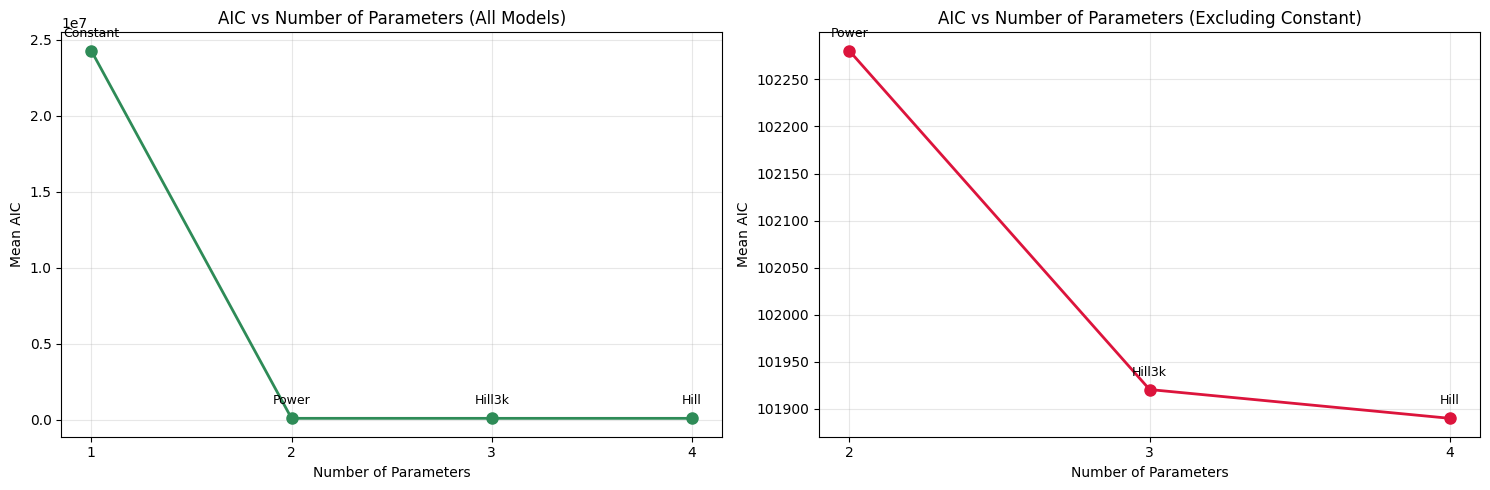

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define the number of parameters for each model
model_params = {
    'AIC_Hill': 4,
    'AIC_Power': 2, 
    'AIC_Hill3k': 3,
    'AIC_Constant': 1
}

# Calculate mean AIC values across all sectors for each model
mean_aic = {}
for col in ['AIC_Hill', 'AIC_Power', 'AIC_Hill3k', 'AIC_Constant']:
    mean_aic[col] = sector_df_aic[col].mean()

# Create comparison dataframe
comparison_data = []
for model, aic_val in mean_aic.items():
    comparison_data.append({
        'Model': model,
        'Parameters': model_params[model],
        'Mean_AIC': aic_val
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Parameters')

# Check if Constant model AIC is very different (outlier)
other_models = comparison_df[comparison_df['Model'] != 'AIC_Constant']['Mean_AIC']
constant_aic = comparison_df[comparison_df['Model'] == 'AIC_Constant']['Mean_AIC'].iloc[0]
aic_range = other_models.max() - other_models.min()
constant_diff = abs(constant_aic - other_models.mean())

# Determine if constant should be excluded (if it's more than 2x the range of other models)
exclude_constant = constant_diff > (2 * aic_range)

print(f"Constant model AIC: {constant_aic:.0f}")
print(f"Other models AIC range: {other_models.min():.0f} - {other_models.max():.0f}")
print(f"Exclude constant model: {exclude_constant}")

# Create plots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: All models including Constant
axes[0].plot(comparison_df['Parameters'], comparison_df['Mean_AIC'], 'ro-', 
            linewidth=2, markersize=8, color='#2E8B57')
axes[0].set_xlabel('Number of Parameters')
axes[0].set_ylabel('Mean AIC')
axes[0].set_title('AIC vs Number of Parameters (All Models)')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks([1, 2, 3, 4])

# Add model labels
for _, row in comparison_df.iterrows():
    model_name = row['Model'].replace('AIC_', '')
    axes[0].annotate(model_name, 
                    (row['Parameters'], row['Mean_AIC']),
                    textcoords="offset points", 
                    xytext=(0,10), 
                    ha='center', fontsize=9)

# Plot 2: Exclude Constant if it's an outlier, otherwise show all
if exclude_constant:
    filtered_df = comparison_df[comparison_df['Model'] != 'AIC_Constant']
    title = 'AIC vs Number of Parameters (Excluding Constant)'
    color = '#DC143C'
else:
    filtered_df = comparison_df
    title = 'AIC vs Number of Parameters (All Models)'
    color = '#2E8B57'

axes[1].plot(filtered_df['Parameters'], filtered_df['Mean_AIC'], 'o-', 
            linewidth=2, markersize=8, color=color)
axes[1].set_xlabel('Number of Parameters')
axes[1].set_ylabel('Mean AIC')
axes[1].set_title(title)
axes[1].grid(True, alpha=0.3)

if exclude_constant:
    axes[1].set_xticks([2, 3, 4])
else:
    axes[1].set_xticks([1, 2, 3, 4])

# Add model labels for second plot
for _, row in filtered_df.iterrows():
    model_name = row['Model'].replace('AIC_', '')
    axes[1].annotate(model_name, 
                    (row['Parameters'], row['Mean_AIC']),
                    textcoords="offset points", 
                    xytext=(0,10), 
                    ha='center', fontsize=9)

plt.tight_layout()
plt.show()

# # Alternative: Create individual sector plots to see variation
# fig, ax = plt.subplots(figsize=(12, 8))

# # Plot each sector as a separate line
# colors = plt.cm.tab10(np.linspace(0, 1, len(sector_df_aic)))

# for i, (_, sector_row) in enumerate(sector_df_aic.iterrows()):
#     sector_name = sector_row['Sector']
    
#     # Get AIC values for this sector
#     sector_aic = [
#         sector_row['AIC_Constant'],  # 1 parameter
#         sector_row['AIC_Power'],     # 2 parameters
#         sector_row['AIC_Hill3k'],    # 3 parameters
#         sector_row['AIC_Hill']       # 4 parameters
#     ]
    
#     parameters = [1, 2, 3, 4]
    
#     # Exclude constant if needed
#     if exclude_constant:
#         sector_aic = sector_aic[1:]  # Remove first element (Constant)
#         parameters = parameters[1:]  # Remove first element (1 parameter)
    
#     ax.plot(parameters, sector_aic, 'o-', 
#            label=f'Sector {sector_name}', 
#            color=colors[i], alpha=0.7, linewidth=1.5)

# ax.set_xlabel('Number of Parameters')
# ax.set_ylabel('AIC')
# if exclude_constant:
#     ax.set_title('AIC vs Number of Parameters by Sector (Excluding Constant)')
#     ax.set_xticks([2, 3, 4])
# else:
#     ax.set_title('AIC vs Number of Parameters by Sector')
#     ax.set_xticks([1, 2, 3, 4])

# ax.grid(True, alpha=0.3)
# ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()
# plt.show()

In [33]:
import plotly.express as px
import plotly.graph_objects as go

def create_plotly_for_your_data(df, hide_constant=True):
    """Create simple Plotly plot of AIC vs Model Type"""
    
    # Get AIC columns
    aic_columns = [col for col in df.columns if col.startswith('AIC_')]
    
    # Option to hide AIC_Constant
    if hide_constant and 'AIC_Constant' in aic_columns:
        aic_columns.remove('AIC_Constant')
    
    # Melt the dataframe
    df_melted = df.melt(id_vars=['Sector'], 
                        value_vars=aic_columns,
                        var_name='Model', 
                        value_name='AIC')
    
    # Clean up model names
    df_melted['Model_Name'] = df_melted['Model'].str.replace('AIC_', '')
    
    # Create the plot
    fig = px.line(df_melted, 
                  x='Model_Name', 
                  y='AIC',
                  color='Sector',
                  markers=True,
                  title='AIC Values by Model Type')
    
    # Add mean line
    mean_data = df_melted.groupby('Model_Name')['AIC'].mean().reset_index()
    
    fig.add_trace(go.Scatter(
        x=mean_data['Model_Name'],
        y=mean_data['AIC'],
        mode='lines+markers',
        name='Mean',
        line=dict(color='black', width=3, dash='dash'),
        marker=dict(size=8)
    ))
    
    # Simple layout
    fig.update_layout(
        xaxis_title="Model Type",
        yaxis_title="AIC (lower is better)",
        hovermode='x unified',
        legend=dict(
            orientation="v",
            yanchor="top",
            y=1,
            xanchor="left",
            x=1.02
        ),
        width=1000,
        height=600
    )
    
    return fig

In [34]:
fig = create_plotly_for_your_data(sector_df_aic)
fig.show()

In [35]:
sector_df_bic = pd.DataFrame({
    'Sector': sector_list,
    'BIC_Hill': sector_bic_hill,
    'BIC_Power': sector_bic_power,
    'BIC_Hill3k': sector_bic_hill3k,
    'BIC_Constant': sector_bic_constant
})
sector_df_bic.head(14)

,Sector,BIC_Hill,BIC_Power,BIC_Hill3k,BIC_Constant
0,G,396609.346555,397899.373311,396637.306043,9.854523e+07
1,M,213805.016750,214228.588287,213804.308890,4.977624e+07
2,F,95583.370000,95589.619076,95580.669120,2.278440e+07
3,J,113973.307269,114312.078238,113976.058615,2.775384e+07
4,K,112445.797295,112838.014142,112441.024525,2.481625e+07
5,C,79091.118501,79198.575237,79095.041809,1.788151e+07
6,H,85969.743534,88012.409338,86260.442868,1.962411e+07
7,S,71524.616015,71931.710225,71536.716333,1.710178e+07
8,N,74044.686806,74213.276478,74091.568759,1.756620e+07
9,I,68515.168888,68588.478516,68527.762115,1.725667e+07


In [36]:
df_long = region_df_aic.melt(id_vars="Region", 
                  var_name="Model", 
                  value_name="AIC_Value")


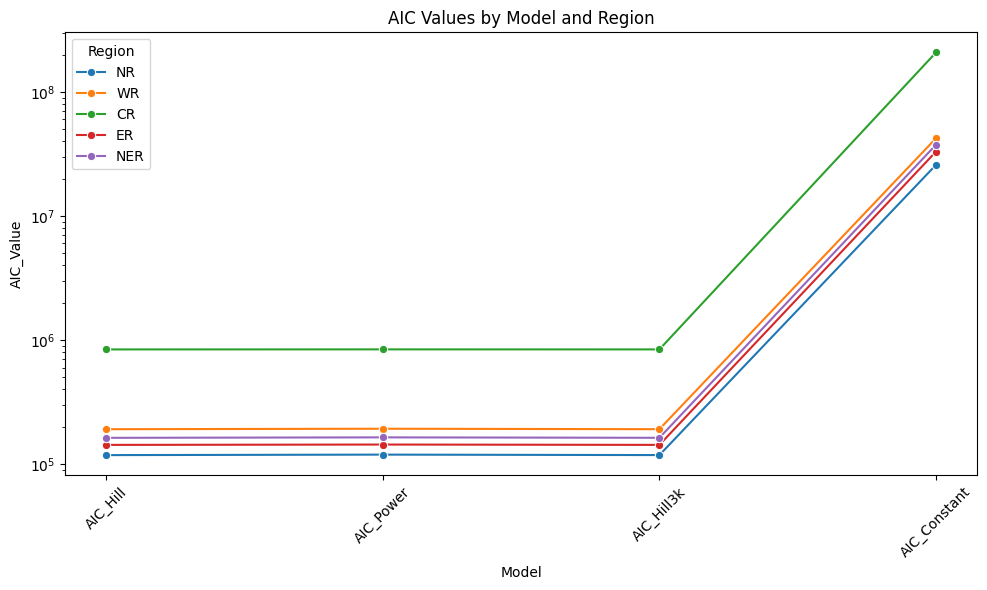

In [37]:
# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_long, x="Model", y="AIC_Value", hue="Region", marker="o")
plt.xticks(rotation=45)
plt.title("AIC Values by Model and Region")
plt.yscale("log")
plt.tight_layout()
plt.show()

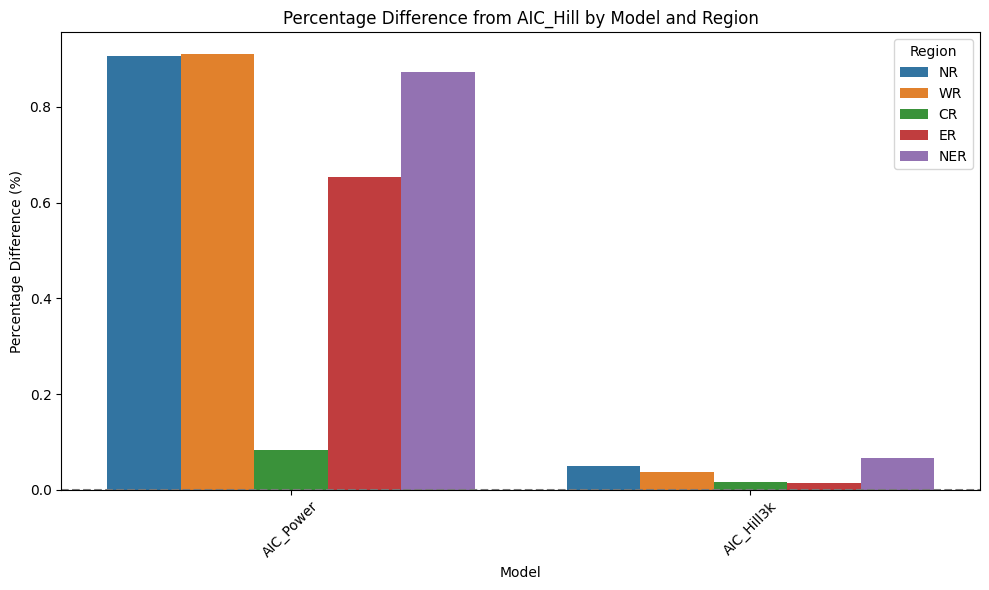

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Original AIC values
dftest = region_df_aic.copy()

# Step 1: Calculate % difference from AIC_Hill
base_model = "AIC_Hill"
compare_models = ["AIC_Power", "AIC_Hill3k"]
dftest_diff = dftest[["Region", base_model] + compare_models].copy()

# Compute percentage differences
for model in compare_models:
    dftest_diff[model] = 100 * (dftest_diff[model] - dftest_diff[base_model]) / dftest_diff[base_model]

# Step 2: Reshape for plotting
dftest_melted = dftest_diff.melt(id_vars="Region", 
                         value_vars=compare_models, 
                         var_name="Model", 
                         value_name="Percent_Diff")

# Step 3: Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=dftest_melted, x="Model", y="Percent_Diff", hue="Region")
plt.axhline(0, color='gray', linestyle='--')
plt.title("Percentage Difference from AIC_Hill by Model and Region")
plt.ylabel("Percentage Difference (%)")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

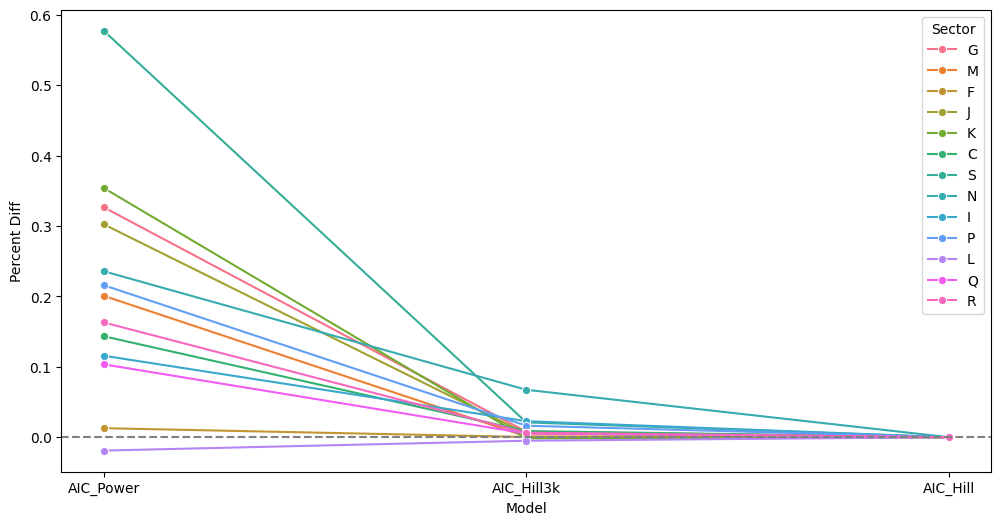

In [117]:
# Line plot % difference from AIC_Hill for sectors
dftest_sector = sector_df_aic.copy()
dftest_sector = dftest_sector[dftest_sector["Sector"] != "H"] 
dftest_sector_diff = dftest_sector[["Sector", base_model] + compare_models].copy()
# Compute percentage differences
for model in compare_models+[base_model]:
    dftest_sector_diff[model] = 100 * (dftest_sector_diff[model] - dftest_sector_diff[base_model]) / dftest_sector_diff[base_model]
    # Reshape for plotting
    dftest_sector_melted = dftest_sector_diff.melt(id_vars="Sector", 
                            value_vars=compare_models+[base_model], 
                            var_name="Model", 
                            value_name="Percent Diff")
# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=dftest_sector_melted, x="Model", y="Percent Diff", hue="Sector", marker="o")
plt.axhline(0, color='gray', linestyle='--')
plt.show()

params mu_ub, mu_lb, K, m for NR are [0.13699737059400022, 0.023557815372955357, 8.31380437771796, 100.0]
params mu_ub, mu_lb, K, m for WR are [0.139078810331312, 0.02564057762124559, 8.486254711280843, 100.0]
params mu_ub, mu_lb, K, m for CR are [0.10414114285388636, 1.0000002600891254e-10, 24.472059126233113, 3.717554873029177]
params mu_ub, mu_lb, K, m for ER are [0.14743279585190008, 0.03815368490403282, 8.499639794541732, 100.0]
params mu_ub, mu_lb, K, m for NER are [0.15153779041951448, 0.03569549946261082, 8.27565878754413, 100.0]


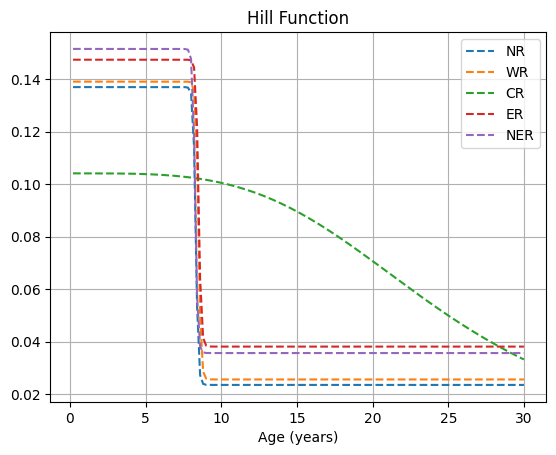

In [40]:
for fil in region_list:

    sf, ages = obtain_survival_fractions(df_analysis, 'Region', fil)

    totals, survivors = obtain_total_alive_count(df_analysis, 'Region', fil)

    mu_ub, mu_lb, K, m = fit_hill_model_mle(ages, survivors, totals).x

    print(f'params mu_ub, mu_lb, K, m for {fil} are {[float(x) for x in [mu_ub, mu_lb, K, m]]}')

    plt.plot(ages, hill_hazard(ages, mu_ub, mu_lb, K, m), label = fil, linestyle='--')
plt.title(f'Hill Function')
plt.xlabel('Age (years)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
sector_list = ['G', 'M', 'F', 'J', 'K', 'C', 'H', 'S', 'N', 'I', 'P', 'L', 'Q', 'R']
parameters = [
    [0.13660027, 0.03574423, 12.39113424, 4.14356328],
    [0.10877533, 0.0418096, 12.55269306, 4.41391222],
    [0.079990154, 1.00E-10, 26.18237719, 79.99986416],
    [0.13090805, 0.03791174, 11.9429807, 4.05657508],
    [0.070120134, 0.011071032, 17.60063205, 11.71975389],
    [0.10301031, 0.04128293, 9.26045477, 8.13925264],
    [0.190143914, 0.028016019, 6.93767599, 100],
    [0.14058029, 1.00E-10, 12.9535533, 5.1898739],
    [0.12396223, 1.00E-10, 16.4327672, 3.67640026],
    [0.12568692, 0.03447114, 17.44283135, 5.60609428],
    [0.121213526, 0.068684245, 9.44518567, 100],
    [0.074121126, 1.00E-10, 25.77531849, 79.99860496],
    [0.078301599, 0.047197935, 7.79197632, 100],
    [0.132289514, 0.085485775, 8.85732298, 100]
]

# Convert to DataFrame
df_params = pd.DataFrame(parameters, 
                        columns=['mu_ub', 'mu_lb', 'K', 'm'],
                        index=sector_list)

df_params.head(14)

,mu_ub,mu_lb,K,m
G,0.136600,3.574423e-02,12.391134,4.143563
M,0.108775,4.180960e-02,12.552693,4.413912
F,0.079990,1.000000e-10,26.182377,79.999864
J,0.130908,3.791174e-02,11.942981,4.056575
K,0.070120,1.107103e-02,17.600632,11.719754
C,0.103010,4.128293e-02,9.260455,8.139253
H,0.190144,2.801602e-02,6.937676,100.000000
S,0.140580,1.000000e-10,12.953553,5.189874
N,0.123962,1.000000e-10,16.432767,3.676400
I,0.125687,3.447114e-02,17.442831,5.606094


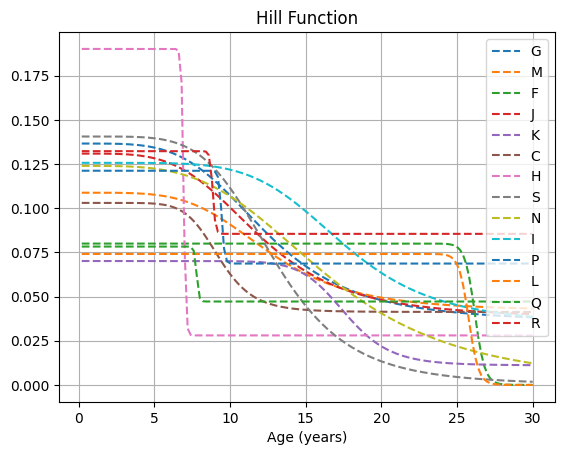

In [ ]:
for param in parameters:

    plt.plot(ages, hill_hazard(ages, *param), label = sector_list[parameters.index(param)], linestyle='--')

plt.title(f'Hill Function')
plt.xlabel('Age (years)')
plt.legend()
plt.grid(True)
plt.show()

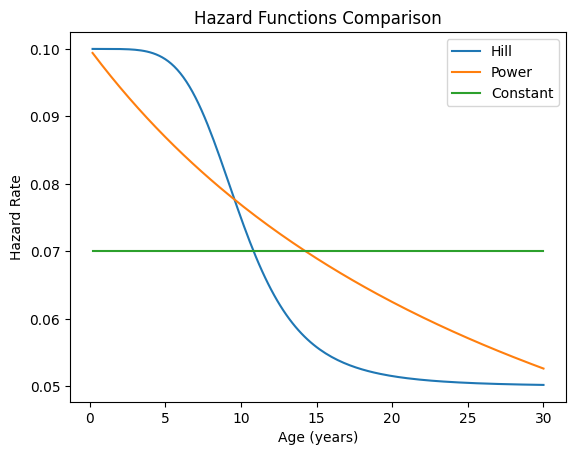

In [100]:
# Compare hazard functions
def power_hazard(a, lam, alpha):
    return lam / (1 + alpha * a)
def constant_hazard(a, mu):
    return mu * np.ones_like(a)

plt.plot(ages, hill_hazard(ages, 0.1, 0.05, 10, 5), label = 'Hill')
plt.plot(ages, power_hazard(ages, 0.1, 0.03), label = 'Power')
plt.plot(ages, constant_hazard(ages, 0.07), label = 'Constant')
plt.title('Hazard Functions Comparison')
plt.xlabel('Age (years)')
plt.ylabel('Hazard Rate')
plt.legend()
plt.show()